<h1 style='text-align:center;'>Best Fraud Classification Model</h1>

## Assignment Notice
Try to use all the techniques we learned (i.e., SMOTE, cross-validation, grid search, pipeline, PCA, etc...) to build the best fraud classification model.

Note: The **'best'** should be defined before you build a model. For example, think of those questions. Which algorithm shows the best performance? Which scoring should be appropriate?

***

**Best란 무엇인가?**
- 이제 Score만으로는 좋은 모델과 나쁜 모델을 분류할 수 없다는 걸 확인했다.
- 특히 불균형 데이터의 경우, 사실 관계와 상관 없이 많은 클래스로 예측하면 성능 자체는 좋아진다.
- **ConfusionMatrix**를 통해 TP, FP, FN, TN을 종합적으로 살펴보는 것이 필요하다.

**Fraud Detection의 경우에는...**
- 머신러닝 모델에서 Precision과 Recall은 반비례한다.
- 즉, [1] 균형을 맞추거나 [2] Precision을 높이거나 [3] Recall을 높일지 선택해야 한다.
- 그러나 Fraud Detection은 특성상 Type II Error를 낮추는 것이 매우 중요하다.
  - FP(사기가 아닌데 사기로 분류)의 경우 약간의 불편함은 존재할 수 있지만, 현실적으로 구제 수단이 많으므로 큰 문제는 되지 않는다.
  - FN(사기인데 일반적 거래로 분류)의 경우 **사기를 탐지할 수 없다**는 점에서 큰 문제가 발생한다.
- 따라서 Fraud Detection에서는 **Recall이 높은 모델**을 좋은 모델로 분류하도록 한다.

## 1. Preparing & Refining Data

이거 pipeline부터 다시 하기.
shap도 쓰고.

In [1]:
from imblearn.over_sampling     import SMOTENC
from sklearn.ensemble           import RandomForestClassifier
from sklearn.metrics            import ConfusionMatrixDisplay
from sklearn.metrics            import confusion_matrix
from sklearn.model_selection    import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree               import DecisionTreeClassifier
from sklearn.tree               import plot_tree
import numpy                    as np
import lightgbm                 as lgb
import pandas                   as pd
import xgboost                  as xgb
import matplotlib.pyplot        as plt
import seaborn                  as sns
from sklearn.linear_model       import LinearRegression
from sklearn.linear_model       import Lasso
from sklearn.linear_model       import Ridge
from sklearn.preprocessing      import RobustScaler
from imblearn.over_sampling     import  RandomOverSampler
from imblearn.over_sampling     import  BorderlineSMOTE
from imblearn.over_sampling     import  SMOTE
from imblearn.under_sampling    import  RandomUnderSampler
from sklearn.neighbors          import  KNeighborsClassifier



from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
import shap
from imblearn.pipeline          import Pipeline

from sklearn.ensemble           import RandomForestClassifier
from sklearn.ensemble           import RandomForestRegressor
from sklearn.model_selection    import train_test_split
import matplotlib.pyplot        as plt
import numpy                    as np
import pandas                   as pd
import shap


ModuleNotFoundError: No module named 'lightgbm'

In [16]:
# making class as we use this so many times
class Fraud:
    def __init__(self):
        self._file = '../data/2_fraud_ex.csv'
        self._df_origin = pd.read_csv(self._file)
        self._df_origin.rename(columns={'oldbalanceOrg':'oldbalanceOrig'}, inplace=True)
        self._types = {'CASH_IN': 0, 'CASH_OUT': 1, 'PAYMENT': 2, 'DEBIT': 3}
        self._df_origin = self._df_origin[['type', 'amount', 'oldbalanceOrig',
            'oldbalanceDest', 'newbalanceDest', 'isFraud']]
        self._df_origin['type'] = self._df_origin['type'].apply(lambda x: self._types.get(x, 4))
        self.reset_df()
        self.RAND_SEED = 0
        self._clf = None
    
    @property
    def types(self):
        return self._types
    
    def reset_df(self):
        self._df = self._df_origin.copy()
        
    @property
    def df(self):
        return self._df
        
    def head(self):
        display(self._df.head())
        
    def make_small(self, ratio=0.1):
        _, self._df_small_origin, _, _ = train_test_split(self._df, self._df['isFraud'],
            test_size=ratio, random_state=self.RAND_SEED, stratify=self._df['isFraud'])
        self.reset_df_small()
        
    @property
    def df_small(self):
        return self._df_small
    
    def prepare_set(self):
        self._df_X = self._df_small.drop(columns='isFraud')
        self._df_y = self._df_small.isFraud

        self._X_train, self._X_test, self._y_train, self._y_test = train_test_split(
            self._df_X, self._df_y, random_state=self.RAND_SEED, stratify=self._df_y)
        self._sm = SMOTENC(categorical_features=[0], random_state=self.RAND_SEED, k_neighbors=7)
        self._X_sm_train, self._y_sm_train = self._sm.fit_resample(self._X_train, self._y_train)
        
    def show_shapes(self):
        print(f'X_train {self._X_train.shape} became {self._X_sm_train.shape}')
        print(f'y_train {self._y_train.shape} became {self._y_sm_train.shape}')
        
    @property
    def df_X(self):
        return self._df_X
    
    @property
    def df_y(self):
        return self._df_y    
    
    def train_data(self):
        return self._X_sm_train, self._y_sm_train
    
    def test_data(self):
        return self._X_test, self._y_test
    
    @property
    def clf(self):
        return self._clf

    @clf.setter
    def clf(self, clf):
        self._clf = clf
    
    def show_score(self, clf=None):
        if clf == None:
            print(f"Train score: {self._clf.score(self._X_sm_train, self._y_sm_train):.3f}")
            print(f"Test score: {self._clf.score(self._X_test, self._y_test):.3f}")
        else:
            print(f"Train score: {clf.score(self._X_sm_train, self._y_sm_train):.3f}")
            print(f"Test score: {clf.score(self._X_test, self._y_test):.3f}")
    
    def show_matrix(self, clf=None):
        plt.figure(figsize=(7, 7))
        if clf == None:
            ConfusionMatrixDisplay.from_estimator(self._clf, self._X_test, self._y_test, display_labels=['Non-Fraud', 'Fraud'])
        else:
            ConfusionMatrixDisplay.from_estimator(clf, self._X_test, self._y_test, display_labels=['Non-Fraud', 'Fraud'])
        plt.show()

    def describe_matrix(self, clf=None):
        if clf == None:
            tn, fp, fn, tp = confusion_matrix(
                self._y_test, self._clf.predict(self._X_test), labels=self._clf.classes_).ravel()
        else:
            tn, fp, fn, tp = confusion_matrix(
                self._y_test, clf.predict(self._X_test), labels=clf.classes_).ravel()

        precision, recall = tp / (tp+fp), tp / (tp+fn)
        pd.options.display.float_format = '{:.3%}'.format
        display(pd.DataFrame({
            'name': ['Accuracy', 'Precision', 'Recall(TPR)', 'F-Score', 'FPR'],
            'value': [(tp+tn) / (tp+tn+fp+fn), precision, recall,
                        2 * (precision*recall) / (precision+recall), fp / (fp+tn)]
        }))

In [17]:
fraud = Fraud()
fraud.head()

fraud.make_small()
fraud.prepare_set()
fraud.show_shapes()

,type,amount,oldbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,2,9839.64,170136.0,0.0,0.0,0
1,2,1864.28,21249.0,0.0,0.0,0
2,4,181.00,181.0,0.0,0.0,1
3,1,181.00,181.0,21182.0,0.0,1
4,2,11668.14,41554.0,0.0,0.0,0


X_train (477196, 5) became (953160, 5)
y_train (477196,) became (953160,)


SMOTE-NC를 활용하여 Imbalanced 문제까진 해결한 상태.

In [18]:
sm = SMOTENC(categorical_features=[0], random_state=fraud.RAND_SEED, k_neighbors=7)
X_sm, y_sm = sm.fit_resample(fraud.df_X, fraud.df_y)

In [19]:
gbm = lgb.LGBMClassifier(num_leaves=5, learning_rate=0.5, random_state=0)
scores = cross_val_score(gbm, X_sm, y_sm)
print('Cross-validation score:', scores)

Cross-validation score: [0.99334716 0.9922495  0.98774865 0.9926783  0.98916105]


In [20]:
res = cross_validate(gbm, X_sm, y_sm, scoring=['accuracy', 'roc_auc', 'recall_macro', "recall_weighted", 
                                           "precision_macro", "precision_weighted","precision", "recall", "f1"], cv=10)
pd.DataFrame(res)

,fit_time,score_time,test_accuracy,test_roc_auc,test_recall_macro,test_recall_weighted,test_precision_macro,test_precision_weighted,test_precision,test_recall,test_f1
0,1.587072,0.292154,0.992706,0.999427,0.992706,0.992706,0.992769,0.992769,0.987208,0.998348,0.992747
1,1.138693,0.349968,0.992997,0.999482,0.992997,0.992997,0.993053,0.993053,0.987793,0.998332,0.993034
2,1.309629,0.339085,0.992061,0.998704,0.992061,0.992061,0.992140,0.992140,0.985890,0.998411,0.992111
3,1.398356,0.519157,0.992509,0.999241,0.992509,0.992509,0.992578,0.992578,0.986734,0.998442,0.992553
4,1.874380,0.449655,0.989708,0.998959,0.989708,0.989708,0.989855,0.989855,0.981375,0.998363,0.989796
5,2.349110,0.654425,0.988984,0.998412,0.988984,0.988984,0.989139,0.989139,0.980440,0.997875,0.989081
6,2.126562,0.604433,0.991982,0.999270,0.991982,0.991982,0.992056,0.992056,0.986009,0.998127,0.992031
7,1.747336,0.449355,0.991722,0.999220,0.991722,0.991722,0.991811,0.991811,0.985201,0.998442,0.991778
8,2.181683,0.512395,0.989724,0.998559,0.989724,0.989724,0.989869,0.989869,0.981420,0.998348,0.989812
9,1.786832,0.441314,0.989527,0.996960,0.989527,0.989527,0.989642,0.989642,0.982144,0.997183,0.989607


In [24]:
param_grid = {
    'num_leaves': [*range(3, 33, 2)], # 3 to 31, step 2
    'max_depth': [-1, *range(3, 13, 2)], # 3 to 11, step 2
    "learning_rate": [0.001, 0.01, 0.1, 0.4, 0.7],
}

# Recall 값이 최대인 모델을 찾아 훈련
grid_search = GridSearchCV(lgb.LGBMClassifier(), param_grid=param_grid, scoring="recall", cv=10, return_train_score=True)
grid_search.fit(*fraud.train_data())

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.4, 0.7],
                         'max_depth': [-1, 3, 5, 7, 9, 11],
                         'num_leaves': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                        25, 27, 29, 31]},
             return_train_score=True, scoring='recall')

In [25]:
print("Optimal Parameters:", grid_search.best_params_)
print("Best Performance Model:", grid_search.best_estimator_)
print(f"Best Cross Validation Score: {grid_search.best_score_:.2f}")
print(f"Test set score: {grid_search.score(*fraud.test_data()):.2f}")

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 9}
Best Performance Model: LGBMClassifier(max_depth=3, num_leaves=9)
Best Cross Validation Score: 1.00
Test set score: 0.98


Train score: 0.982
Test score: 0.964


<Figure size 700x700 with 0 Axes>

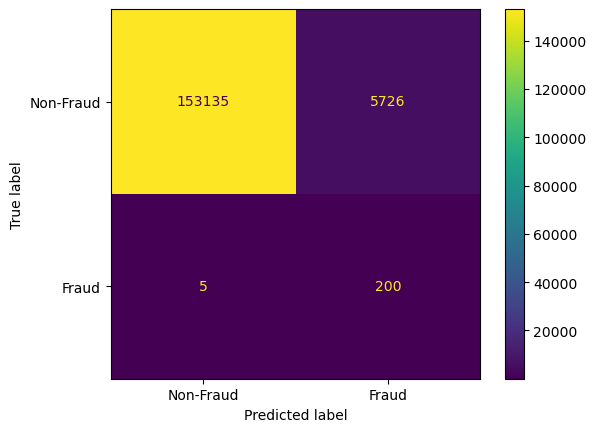

,name,value
0,Accuracy,96.397%
1,Precision,3.375%
2,Recall(TPR),97.561%
3,F-Score,6.524%
4,FPR,3.604%


In [26]:
# parameter 수정
gbm = lgb.LGBMClassifier(learning_rate=0.1, max_depth=3, num_leaves=9,
        random_state=fraud.RAND_SEED).fit(*fraud.train_data())
fraud.clf = gbm
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

**지난번 앙상블 결과**
|name|value|
|---|---|
|Accuracy|98.816%|
|Precision|9.620%|
|Recall(TPR)|97.561%|
|F-Score|17.513%|
|FPR|1.183%|

Accuracy가 오히려 떨어졌다. FP 값이 크게 늘었기 때문이다.\
그리드서치에서 accuracy 값을 고려하지 않아서 생긴 문제같으니,\
다시 돌려보자.

In [28]:
param_grid = {
    'num_leaves': [7, 8, 9, 10],
    'max_depth': [2, 3, 4],
    "learning_rate": [0.01, 0.1, 0.4],
}

# Recall 값이 최대인 모델을 찾아 훈련
grid_search = GridSearchCV(lgb.LGBMClassifier(), param_grid=param_grid,
        scoring=["recall", "accuracy"], refit="recall", cv=10, return_train_score=True)
grid_search.fit(*fraud.train_data())

GridSearchCV(cv=10, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.4],
                         'max_depth': [2, 3, 4], 'num_leaves': [7, 8, 9, 10]},
             refit='recall', return_train_score=True,
             scoring=['recall', 'accuracy'])

In [29]:
print("Optimal Parameters:", grid_search.best_params_)
print("Best Performance Model:", grid_search.best_estimator_)
print(f"Best Cross Validation Score: {grid_search.best_score_:.2f}")
print(f"Test set score: {grid_search.score(*fraud.test_data()):.2f}")

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'num_leaves': 8}
Best Performance Model: LGBMClassifier(max_depth=3, num_leaves=8)
Best Cross Validation Score: 1.00
Test set score: 0.98


Train score: 0.982
Test score: 0.964


<Figure size 700x700 with 0 Axes>

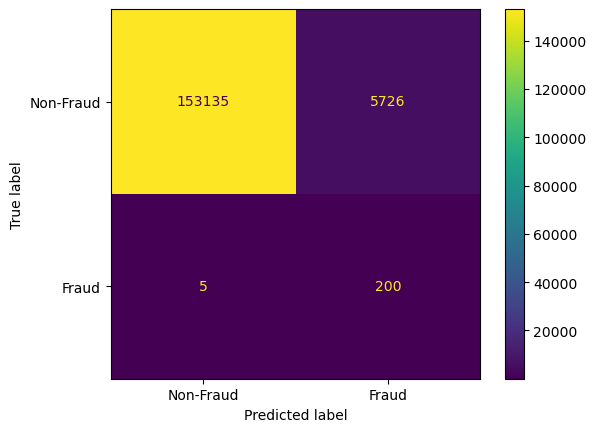

,name,value
0,Accuracy,96.397%
1,Precision,3.375%
2,Recall(TPR),97.561%
3,F-Score,6.524%
4,FPR,3.604%


In [30]:
# parameter 수정
gbm = lgb.LGBMClassifier(learning_rate=0.1, max_depth=3, num_leaves=8,
        random_state=fraud.RAND_SEED).fit(*fraud.train_data())
fraud.clf = gbm
fraud.show_score()
fraud.show_matrix()
fraud.describe_matrix()

모델 빌드에 수 시간이 걸린 관계로 더 이상의 진행은 현실적으로 어렵다고 판단.\
그리드 서치에 사용되는 하이퍼파라미터를 늘리고, recall-accuracy 순으로 높은 모델을 찾는다면\
최적의 모델을 찾을 수 있을 것으로 기대한다.